In [1]:
# //////////////////////////////////////// Imports
import numpy as np
import tensorflow as tf
import pandas as pd
import math

from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Check GPU
print(tf.test.is_built_with_cuda())

True


In [2]:
# //////////////////////////////////////// Load model and data
# model_name = "v1_vacc_0.9585"
model_name = "v2_vacc_0.8186"
import_path = "./trained_models/{}".format(str(model_name))
model = tf.keras.models.load_model(import_path)

# //////////////////////////////////////// Load data
# You will need to unzip the respective batch folders.
# Obviously Batch_0 is not sufficient for testing as you will soon find out.
use_test_data = True # Set to false if other validation batch data is used
batch_nr = 2
if use_test_data:
    test_data_root = "./dataset/Test"
else:
    test_data_root = "./safetyBatches/Batch_" + str(batch_nr) + "/"
train_data_root = "./dataset/Train"

batch_size = 32
# img_height = 224
# img_width = 224
img_height = 96
img_width = 96

train_ds = tf.keras.utils.image_dataset_from_directory(train_data_root + '/')
# Get information on your train classes
train_class_names = np.array(train_ds.class_names)
print("Train Classes available: ", train_class_names)


# Import labels: (Test dataset is unsorted)
train_csv_path = train_data_root + '_label.csv'
train_df = pd.read_csv(filepath_or_buffer=train_csv_path, delimiter=',')
train_labels = train_df['ClassId'].tolist()
test_csv_path = test_data_root + '_label.csv'
test_df = pd.read_csv(filepath_or_buffer=test_csv_path, delimiter=',')
test_labels = test_df['ClassId'].tolist()

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=test_data_root + '/',
    labels=test_labels,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
)

files = test_ds.file_paths
# Get information on your val classes
class_names = np.array(test_ds.class_names)
print("Val Classes available: ", class_names)

if not use_test_data:
    # get the ground truth labels
    test_labels = np.concatenate([y for x, y in test_ds], axis=0)
    # Mapping test labels to the folder names instead of the index
    for i in range(0, len(test_labels)):
        test_labels[i] = int(class_names[test_labels[i]])
else:
    test_labels = test_labels


Found 39209 files belonging to 43 classes.
Train Classes available:  ['0' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21'
 '22' '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35'
 '36' '37' '38' '39' '4' '40' '41' '42' '5' '6' '7' '8' '9']
Found 12630 files belonging to 1 classes.
Val Classes available:  ['00']


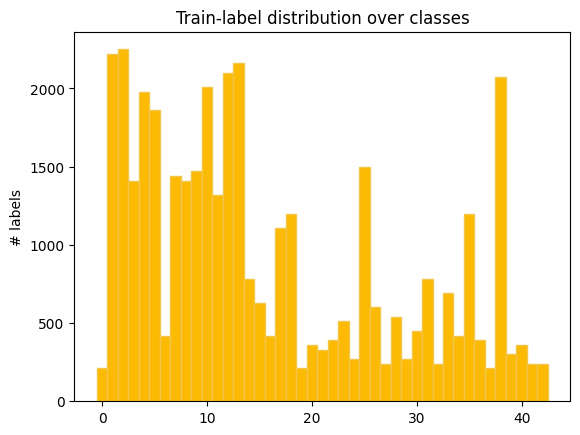

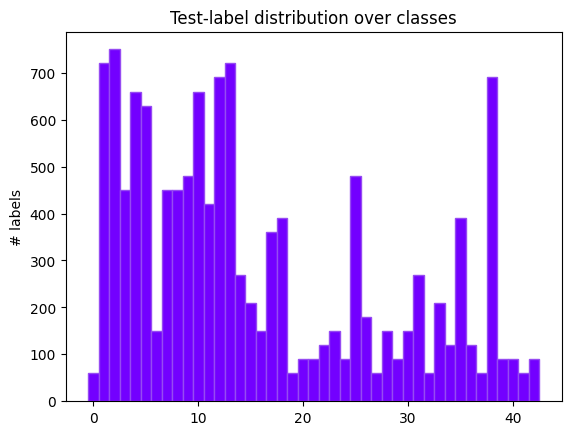

In [3]:
#/////////////////////////////////////// Data Analysis
# Plot class histogram to show dataset bias
train_class_names_int = [int(cls) for cls in train_class_names]
plt.hist(train_labels, bins=[idx - 0.5 for idx in range(0, max(train_class_names_int)+2)], ec='#f2c64b',color='#fcba03')
plt.title('Train-label distribution over classes')
plt.ylabel('# labels')
plt.show()
plt.hist(test_labels, bins=[idx - 0.5 for idx in range(0, max(train_class_names_int)+2)], ec='#964bf2',color='#7300ff')
plt.title('Test-label distribution over classes')
plt.ylabel('# labels')
plt.show()

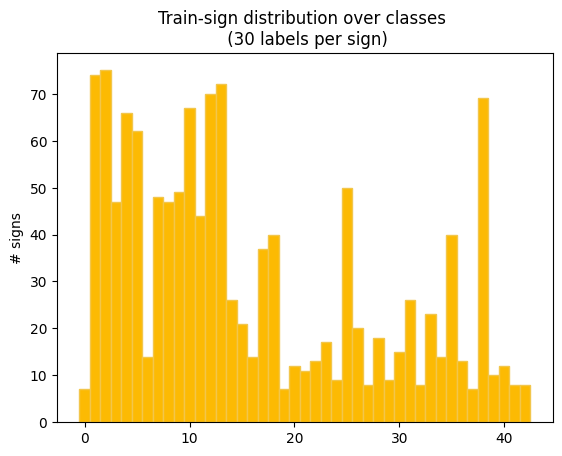

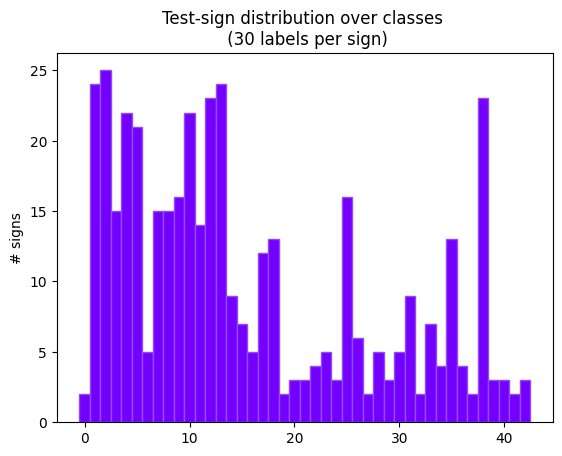

In [4]:
# Plot class histogram for different signs (one sign per 30 labels)
train_class_names_int = [int(cls) for cls in train_class_names]
x, bins = np.histogram(train_labels, bins=range(0, max(train_class_names_int)+2))
plt.bar(bins[:-1],x/30,width=1, ec='#f2c64b',color='#fcba03')
plt.title('Train-sign distribution over classes \n (30 labels per sign)')
plt.ylabel('# signs')
plt.show()
x, bins = np.histogram(test_labels, bins=range(0, max(train_class_names_int)+2))
plt.bar(bins[:-1],x/30,width=1,ec='#964bf2',color='#7300ff')
plt.title('Test-sign distribution over classes \n (30 labels per sign)')
plt.ylabel('# signs')
plt.show()

In [5]:
#/////////////////////////////////////// Prediction
# Remember that we had some preprocessing before our training this needs to be repeated here
# Preprocessing as the tensorflow hub models expect images as float inputs [0,1]
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
test_ds = test_ds.map(
    lambda x, y: (normalization_layer(x), y)
)  # Where x—images, y—labels.

# //////////////////////////////////////// Inference.
predictions = model.predict(test_ds)
predictions = np.argmax(predictions, axis=1)

# Mapping the prediction class id based on the folder names
for i in range(0, len(predictions)):
    predictions[i] = int(train_class_names[predictions[i]])

predictions = predictions.tolist()

print("Predictions: ", predictions[:10])
print("Ground truth: ", test_labels[:10])

Predictions:  [16  1 38 33 11 38 11 12 25 35]
Ground truth:  [16, 1, 38, 33, 11, 38, 18, 12, 25, 35]


# Validation
## Metrics

C:\Users\manue\AppData\Local\Temp\ipykernel_5188\16748218.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(average_metrics, ignore_index=True)


    Class  Precision    Recall  Average Precision
0     1.0   0.500000  0.166667           0.087292
1     2.0   0.597990  0.495833           0.325244
2     3.0   0.427778  0.410667           0.210670
3     4.0   0.308642  0.222222           0.096299
4     5.0   0.467911  0.607576           0.304798
5     6.0   0.442757  0.601587           0.286230
6     7.0   0.921260  0.780000           0.721196
7     8.0   0.643766  0.562222           0.377537
8     9.0   0.451292  0.504444           0.245308
9    10.0   0.703704  0.672917           0.485965
10   11.0   0.673611  0.734848           0.508858
11   12.0   0.477137  0.571429           0.286902
12   13.0   0.912732  0.924638           0.848064
13   14.0   0.946133  0.951389           0.902911
14   15.0   0.886861  0.900000           0.800313
15   16.0   0.924171  0.928571           0.859346
16   17.0   0.837209  0.720000           0.606116
17   18.0   0.923977  0.877778           0.814530
18   19.0   0.611413  0.576923           0.365802


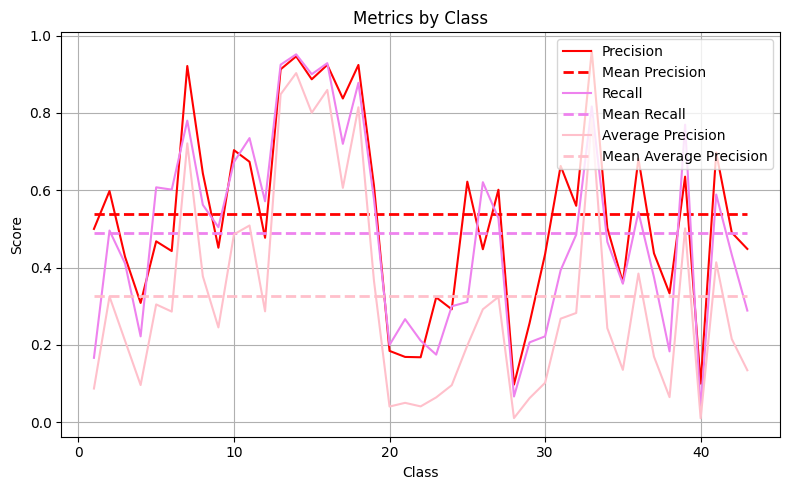

In [17]:
#///////////////////////////////Metrics
# Before a statement over the general performance of the model is made, a more in depth metric evaluation, differentiating the particular classes, is done.
# This also helps to calculate the MAP-Metric later on
# Preprocessing
num_classes = max(train_class_names_int) + 1
# For AP calculation test_labels and precision needs to be converted to multilabel-indicator format
mlb = MultiLabelBinarizer()
ap_test_labels = mlb.fit_transform([[label] for label in test_labels])
ap_predictions = mlb.fit_transform([[pred] for pred in predictions])

# First, calculate precision, recall, and average precision for each class
precision = metrics.precision_score(test_labels, predictions, average=None, labels=np.arange(num_classes))
recall = metrics.recall_score(test_labels, predictions, average=None, labels=np.arange(num_classes))
accuracy = metrics.accuracy_score(test_labels, predictions)  # , average=None, labels=np.arange(num_classes))
average_precision = metrics.average_precision_score(ap_test_labels, ap_predictions, average=None) #, labels=np.arange(num_classes))

# Create a Pandas DataFrame with the metrics for each class
metrics_df = pd.DataFrame({'Class': np.arange(num_classes)+1,
                           'Precision': precision,
                           'Recall': recall,
                           'Average Precision': average_precision})

# Add the average of each metrics over all classes
average_metrics = {
    'Precision': metrics_df['Precision'].mean(),
    'Recall': metrics_df['Recall'].mean(),
    'Average Precision': metrics_df['Average Precision'].mean()
}
metrics_df = metrics_df.append(average_metrics, ignore_index=True)
# Show values
print(metrics_df)
print("===========\n"
      "Main metrics: \n"
      "-----------\n"
      "Accuracy: " + str(accuracy) + "\n"
      "Mean Recall: " + str(average_metrics['Recall']) + "\n"
      "Mean Precision: " + str(average_metrics['Precision']) + "\n"
      "MAP: " + str(average_metrics['Average Precision']) + "\n"
      "===========\n")
# Plot as line plot
class_labels = metrics_df['Class'].values[:-1]  # Exclude the last row (average metrics)
metrics_columns = ['Precision', 'Recall', 'Average Precision']
metrics_color = ['red', 'violet', 'pink']
# metrics_color = ['blue', 'cyan', 'pink']
mean_metrics = metrics_df[metrics_columns].iloc[:-1].mean().values
plt.figure(figsize=(8, 5))
for i in range(len(metrics_columns)):
    plt.plot(class_labels, metrics_df[metrics_columns[i]].values[:-1], label=metrics_columns[i], color=metrics_color[i])
    # Mean line:
    plt.plot(class_labels, [mean_metrics[i]] * num_classes, linestyle='--', color=metrics_color[i], linewidth=2, label='Mean '+metrics_columns[i])

# Formatting the line plot
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Metrics by Class')
plt.legend()
plt.grid(True)

# Displaying the plots
plt.tight_layout()
plt.show()


## Plots

To get more information about the detection results, two plotting tools are introduced: A plot of some wrong detected images and the overview of all mismatches in a error matrix.

In [19]:
def format_string2max(text, max_len):
    out_str = ""
    dif = 0
    for i, letter in enumerate(text):
        if ((i-dif) % max_len == 0) and (i != 0):
            out_str += '\n'
        out_str += letter
        if letter == '\n':
            dif += i
    return out_str

In [20]:
# Show wrongly classified data
class_names_df = pd.read_csv("./signnames.csv", index_col="ClassId")
print(f'Test: | Class ID: {predictions[0]} Class Name: {class_names_df["SignName"][predictions[0]]}')
idx_wrong_class = [i for i in range(0, len(predictions)) if predictions[i] != test_labels[i]]

C:\Users\manue\AppData\Local\Temp\ipykernel_5188\2948967560.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(num_cells, num_cells, i + 1)


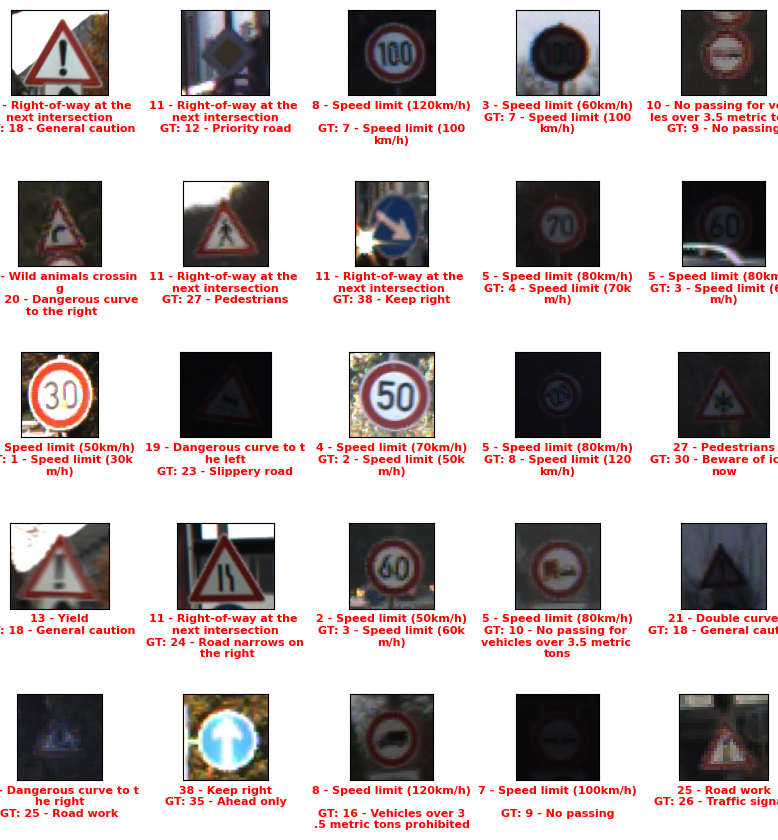

In [43]:
# cut too much data
num_cut = 25
if len(idx_wrong_class)>=num_cut:
    idx_wrong_class_cut = idx_wrong_class[:num_cut]
else:
    idx_wrong_class_cut = idx_wrong_class
numbers_to_display = len(idx_wrong_class_cut)
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(10, 10))

for i in range(0, len(idx_wrong_class_cut)):
    idx = idx_wrong_class_cut[i]
    predicted_label = f'{predictions[idx]} - {class_names_df["SignName"][predictions[idx]]}\n' \
                      f'GT: {test_labels[idx]} - {class_names_df["SignName"][test_labels[idx]]}'
    predicted_label = format_string2max(predicted_label, 25)
    plt.grid(False)
    plt.subplot(num_cells, num_cells, i + 1)
    img = mpimg.imread(files[idx])
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    font = {'color': 'green', 'weight': 'normal', 'size': 8} if predictions[idx] == test_labels[idx] \
        else {'color': 'red', 'weight': 'bold', 'size': 8}
    plt.xlabel(predicted_label,  fontdict=font)

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.savefig('wrong_detects.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
# Plot error matrix by first calculating all mismatches
num_cls = len(class_names_df)
error_matrix_df = pd.DataFrame(np.zeros((num_cls, num_cls)))
# print(error_matrix_df)
for i in range(0, len(idx_wrong_class)):
    idx = idx_wrong_class[i]
    error_matrix_df.loc[test_labels[idx], predictions[idx]] = error_matrix_df.loc[test_labels[idx], predictions[idx]] + 1
error_matrix_df.columns = class_names_df["SignName"].tolist()
error_matrix_df.index = class_names_df["SignName"].tolist()

<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

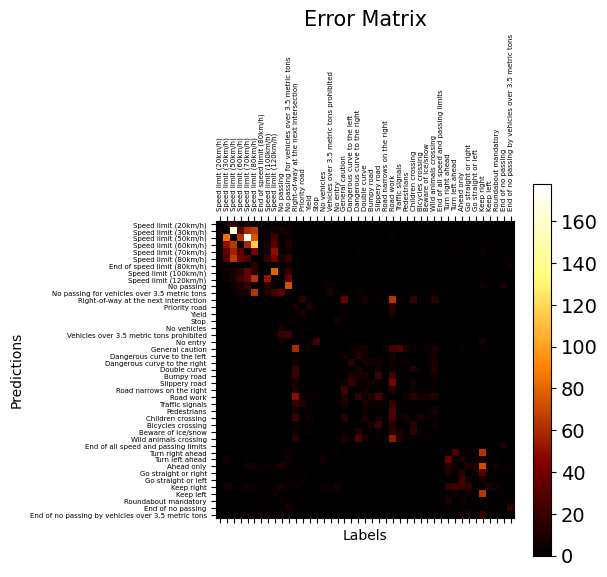

Max error count: 178.0    Min error count: 0.0


In [42]:
# rescale for better visualisation
fig = plt.gcf()
plt.figure(figsize=(10, 10))
plt.matshow(error_matrix_df, cmap='afmhot')
plt.xticks(range(len(class_names_df)), class_names_df["SignName"].tolist(), fontsize=5, rotation=90)
plt.yticks(range(len(class_names_df)), class_names_df["SignName"].tolist(), fontsize=5)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Error Matrix', fontsize=15);
plt.ylabel('Predictions')
plt.xlabel('Labels')
plt.savefig('error_matrix.jpg', dpi=300, bbox_inches='tight')
plt.show()
print("Max error count: " + str(error_matrix_df.max().max()) + "    Min error count: " + str(error_matrix_df.min().min()))

## Data augmentation & Validation batch

After having a detailed look on the prediction results, it's clear that there needs to be a better training and validation set. The detection errors between signs of the same shape and color (e.g. class 0 - 10 and 33 - 40) is extremely high. While a longer training might result in a better outcome, the risk of overfitting also rises. To achive a more robust detection model,
- the model itself is improved (Different feature extractor, dropout layer) -> See kickstart.py
- the validation set is supplemented by new pictures (Meta and internet) to improve biased class imbalance
- the trainings set is augmented by rotated, hidden and noisy versions of the images
- same is done for the validation batch

In [ ]:
#///////////////////////////Augmentation
# For more robust results a ImageDataGenerator is used: (See kickstart.py) Credit for idea: https://www.kaggle.com/code/shivank856/gtsrb-cnn-98-test-accuracy
aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,  # Not allowed as a flipped sign has a different meaning!
    vertical_flip=False,    # Same here...
    fill_mode="nearest")

batches = 0
for x_batch, y_batch in aug.flow(x_val, y_val, batch_size=32):
    model.fit(x_batch, y_batch)